In [35]:
import numpy as np
import pandas as pd
import sklearn as skl
import sklearn.neighbors
import scipy
import scipy.spatial as sp
import scipy.stats as st
import gudhi
import matplotlib.pyplot as plt
import tqdm
import os
import os.path as osp
import gudhi.point_cloud as gpc

In [36]:
base_dir = '~/CaiLab/dna-if-analysis/'
df_1 = pd.read_csv(osp.join(base_dir, 'data/DNAseqFISH+1Mbloci-E14-replicate1.csv'))
df_1['rep'] = 1
df_2 = pd.read_csv(osp.join(base_dir, 'data/DNAseqFISH+1Mbloci-E14-replicate2.csv'))
df_2['rep'] = 2

dna_df = pd.concat([df_1, df_2])
order = pd.read_csv(osp.join(base_dir, 'data/TableS0_Mbcoords.csv'))

In [14]:
dna_df = dna_df.merge(order, left_on='geneID', right_on='Name', how='left')

dna_df.head()

fov  cellID  channel    geneID         x        y       z  seeds  \
0    0       1        1   chr1-#1  1690.475  166.783   9.566      5   
1    0       1        1  chr1-#11  1691.842  148.135  10.158      5   
2    0       1        1  chr1-#13  1611.480  202.516   9.985      4   
3    0       1        1  chr1-#13  1700.680  144.291   9.492      4   
4    0       1        1  chr1-#13  1603.773  185.353   8.697      5   

   intensity  rep  Unnamed: 0  Region ID      Name  Channel Chrom     Start  \
0       1690    1         NaN          1   chr1-#1        1  chr1   3100000   
1       1692    1         NaN         18  chr1-#11        1  chr1  23000000   
2       1611    1         NaN         22  chr1-#13        1  chr1  27225000   
3       1701    1         NaN         22  chr1-#13        1  chr1  27225000   
4       1604    1         NaN         22  chr1-#13        1  chr1  27225000   

        End  Chrom ID  
0   3125000         1  
1  23025000         1  
2  27250000         1  
3  27250000         1  
4  27250000         1

In [15]:
rep = 2
fov = 3
cellid = 29

In [16]:
test_cell = dna_df.query('rep==@rep & fov==@fov & cellID==@cellid').copy()
test_cell.head()

fov  cellID  channel   geneID         x         y      z  seeds  \
1039835    3      29        1  chr1-#1  1008.002  1734.173  6.126      5   
1039836    3      29        1  chr1-#1  1114.356  1842.857  5.607      4   
1039837    3      29        1  chr1-#1   972.261  1698.760  7.184      5   
1039838    3      29        1  chr1-#1   997.269  1720.646  5.180      4   
1039839    3      29        1  chr1-#1  1110.841  1845.096  5.379      4   

         intensity  rep  Unnamed: 0  Region ID     Name  Channel Chrom  \
1039835       1008    2    334692.0          1  chr1-#1        1  chr1   
1039836       1114    2    334693.0          1  chr1-#1        1  chr1   
1039837        972    2    334694.0          1  chr1-#1        1  chr1   
1039838        997    2    334695.0          1  chr1-#1        1  chr1   
1039839       1111    2    334696.0          1  chr1-#1        1  chr1   

           Start      End  Chrom ID  
1039835  3100000  3125000         1  
1039836  3100000  3125000         1  
1039837  3100000  3125000         1  
1039838  3100000  3125000         1  
1039839  3100000  3125000         1

In [17]:
if_test = pd.read_hdf(f'../../../IF_converted/Rep3-1/IF_Rep{rep}_Pos{fov}_Cell{cellid}_wide.hd5',)


if_test['x'] = (103.*(if_test['xIdx']-1)).astype(int)
if_test['y'] = (103.*(if_test['yIdx']-1)).astype(int)
if_test['z'] = (250.*(if_test['zIdx']-1)).astype(int)
if_test.head()

zIdx  xIdx  yIdx  LINE1  Telomere  MinSat  mH2A1  H3pSer10  H3K9ac  \
0     1   960  1712    484         0       0    498       453     526   
1     1   960  1713    483         0       0    512       457     541   
2     1   960  1714    477         0       0    514       458     536   
3     1   960  1715    481         0       0    516       434     516   
4     1   960  1716    482         0       0    512       459     529   

   H3K9me2  ...  H3K27me2  SF3a66  H3K27me3  H4K20me3  Lamin B1  H4K16ac  \
0      527  ...       311     222       317       195       242        0   
1      575  ...       311     232       311       213       246        0   
2      546  ...       307     232       302       197       245        0   
3      508  ...       312     223       294       195       237        0   
4      538  ...       305     223       303       197       245        0   

   DAPI      x       y  z  
0     0  98777  176233  0  
1     0  98777  176336  0  
2     0  98777  176439  0  
3     0  98777  176542  0  
4     0  98777  176645  0  

[5 rows x 27 columns]

In [18]:
bbox_min = (if_test['xIdx'].min(), if_test['yIdx'].min())
bbox_min

(960, 1640)

1 unit in the rescaled coordinates is equal to 300 XY pixels, so $103\times 300 = 30900\text{ nm}$.  

The extent of the Z axis is $25\times 250 = 6250\text{ nm}$ so the rescaled Z coordinate goes from 0 to $\frac{6250}{30900}=0.2023$

In [19]:
test_cell['x rel'] = ((test_cell['x'] - bbox_min[0]) / 300)
test_cell['y rel'] = ((test_cell['y'] - bbox_min[1]) / 300)
test_cell['z rel'] = ((test_cell['z'] / (25))) * 6250 / 30900

In [20]:
test_cell['z rel'].max()

0.1261326860841424

In [21]:
if_test['xIdx rel'] = if_test['xIdx'] - bbox_min[0]
if_test['yIdx rel'] = if_test['yIdx'] - bbox_min[1]
if_test['zIdx rel'] = if_test['zIdx'] - 1

if_test['x rel'] = (if_test['xIdx'] - bbox_min[0]) / 300
if_test['y rel'] = (if_test['yIdx'] - bbox_min[1]) / 300
if_test['z rel'] = (if_test['zIdx'] - 1)/25 * 6250 / 30900

In [22]:
x_if = np.linspace(if_test['x rel'].min(), 
                   if_test['x rel'].max(), 
                   num=if_test['xIdx'].max()-if_test['xIdx'].min()
                )

y_if = np.linspace(if_test['y rel'].min(), 
                   if_test['y rel'].max(), 
                   num=if_test['yIdx'].max()-if_test['yIdx'].min()
                )

z_if = np.linspace(if_test['z rel'].min(),
                   if_test['z rel'].max(),
                   num=25
                )

if_bbox = (if_test['xIdx'].max()-if_test['xIdx'].min(), if_test['yIdx'].max()-if_test['yIdx'].min(), 25)

x, y, z = np.meshgrid(x_if, y_if, z_if)

if_grid = np.vstack((np.ravel(x), np.ravel(y), np.ravel(z))).T

In [23]:
if_bbox

(198, 222, 25)

In [44]:
if_grid.shape

(1098900, 3)

In [13]:
xy_norm = np.linspace(0, 1, num=300)
z_norm = np.linspace(0, 0.2023, num=25)

z_norm

array([0.        , 0.00842917, 0.01685833, 0.0252875 , 0.03371667,
       0.04214583, 0.050575  , 0.05900417, 0.06743333, 0.0758625 ,
       0.08429167, 0.09272083, 0.10115   , 0.10957917, 0.11800833,
       0.1264375 , 0.13486667, 0.14329583, 0.151725  , 0.16015417,
       0.16858333, 0.1770125 , 0.18544167, 0.19387083, 0.2023    ])

In [14]:
x, y, z = np.meshgrid(xy_norm, xy_norm, z_norm)

uniform_grid = np.vstack((np.ravel(x), np.ravel(y), np.ravel(z))).T

In [15]:
uniform_grid[-1]

array([1.    , 1.    , 0.2023])

* Should use common bounding box size so that normalized spatial units and densities are equal across cells
* Should get counts of each chromosome per cell from original dataframe (most regions should show up n times). Possibly still make within-cell density sum to 1, but when comparing cells i.e. level sets of chromosome density, may want to multiply density of each chr by its multiplicity so that within-single-chromosome densities are uniform.
* Could include intron FISH as extra density dimension(s), maybe not a dimension for each unique gene, but perhaps for genes on each chromosome, or just all genes together


* Would be good to think of some standard metrics or tests to compare different parameters and methods - for example, a couple cells to always compare, and ideally some existing/classic analysis methods like PCA etc
    * Perhaps comparing clustering of voxels to that in the paper - use the same cell as in figure 3 (seemed to be hierarchical then UMAP visualization)
    * Figure 4 basic comparison of chromosome distances in clonal experiment - probably Pearson R of distance matrices
    * PCA / conventional clustering of the IF mark-only matrix versus including the chromosomal density dimensions
    * From PCA of chroms and IF - do you see A/B compartent?
    * Recapitulate similar 'fixed' loci - may need to ask for list of them; identifying 2D surfaces in 3D data


* Plot spatial distance versus hi-D distance for pairs of voxels including chromosome density info
* Support estimation and low-D embedding estimation of ~40 D points; persistence based clustering?
* Between cells optimal transport or other prob dist distance ideas between dists in 40D space (L1 metric?)
    * Wasserstein, Gromov-Hausdorff metrics
    * Obstruction theory, surgery theory
    
* Vectors between cell centroids , then vector connecting each locus with its counterpart in the other cell; similarity reflected somehow in a simple relationship among all these vectors (i.e. cell2's configuration just some simple rotation or translation of loci, not "mixing up")


In [16]:
def make_bbox(coords, dim=None,):
    coords = coords.astype(float)
    maxes = np.max(coords, axis=0)
    mins  = np.min(coords, axis=0)
    
    if dim is None:
        dim = len(maxes)
        
    return (mins[:dim], maxes[:dim])


def normalize_grid(coords, bbox=None):
    if bbox is None:
        bbox = make_bbox(coords)
    
    result = np.zeros_like(coords.T, dtype=float)
    
    for dim in range(coords.T.shape[0]):
        result[dim] = (coords.T[dim] - bbox[0][dim]) / (bbox[1][dim] - bbox[0][dim])
    
    return result.T


## Testing

* Evaluate 3D density
* Plot one slice from the middle

## Gaussian KDE
Scipy or sklearn
By default, uses "Scotts Rule" for bandwidth, $n^{-(d+4)}$ where $n$ number of datapoints and $d$ dimension. For my case, each cell has $n \approx 5000$, or
each chromosome has $n \approx 200$, and $d=3$.

In [17]:
def scott_bw(data):
    n = data.shape[0]
    d = data.shape[1]
    
    return n**(-1./(d+4))

In [18]:
scott_bw(test_cell_normalized)

NameError: name 'test_cell_normalized' is not defined

In [19]:
kde_kern = skl.neighbors.KernelDensity(
    bandwidth=0.03,
    kernel='gaussian',
    metric='euclidean',
    rtol=0.01,
    algorithm='ball_tree',
    leaf_size=20
)

In [20]:
test_cell.head()

fov  cellID  channel   geneID         x         y      z  seeds  \
1039835    3      29        1  chr1-#1  1008.002  1734.173  6.126      5   
1039836    3      29        1  chr1-#1  1114.356  1842.857  5.607      4   
1039837    3      29        1  chr1-#1   972.261  1698.760  7.184      5   
1039838    3      29        1  chr1-#1   997.269  1720.646  5.180      4   
1039839    3      29        1  chr1-#1  1110.841  1845.096  5.379      4   

         intensity  rep  ...  Region ID     Name Channel  Chrom    Start  \
1039835       1008    2  ...          1  chr1-#1       1   chr1  3100000   
1039836       1114    2  ...          1  chr1-#1       1   chr1  3100000   
1039837        972    2  ...          1  chr1-#1       1   chr1  3100000   
1039838        997    2  ...          1  chr1-#1       1   chr1  3100000   
1039839       1111    2  ...          1  chr1-#1       1   chr1  3100000   

             End  Chrom ID     x rel     y rel     z rel  
1039835  3125000         1  0.160007  0.313910  0.049563  
1039836  3125000         1  0.514520  0.676190  0.045364  
1039837  3125000         1  0.040870  0.195867  0.058123  
1039838  3125000         1  0.124230  0.268820  0.041909  
1039839  3125000         1  0.502803  0.683653  0.043519  

[5 rows x 21 columns]

In [21]:
len(uniform_grid)

2250000

In [9]:
test_cell_coords = test_cell[['x rel', 'y rel', 'z rel']].values

NameError: name 'test_cell' is not defined

In [57]:
kde_kern.fit(test_cell_coords)

kde_cell = np.exp(kde_kern.score_samples(uniform_grid[:]))

In [58]:
kde_cell = kde_cell.reshape((300, 300, 25)) / np.sum(kde_cell)

In [52]:
if_bbox

(198, 222, 25)

In [53]:
198*222*25

1098900

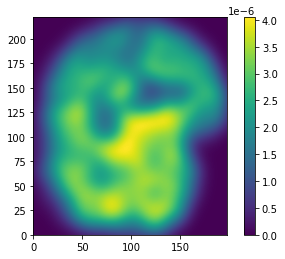

In [59]:
fig, ax = plt.subplots()
im = ax.imshow(kde_cell[:, :, 10],)
ax.set_xlim([0, if_bbox[0]])
ax.set_ylim([0, if_bbox[1]])
fig.colorbar(im)

plt.show()

In [91]:
test_chr2 = test_cell.query('`Chrom ID`==2')[['x rel', 'y rel', 'z rel']].values
kde_kern.fit(test_chr2)

kde_chr2 = np.exp(kde_kern.score_samples(uniform_grid))

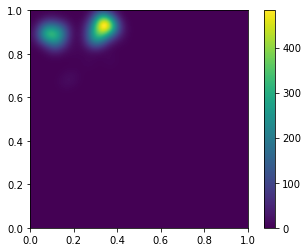

In [97]:
kde_chr2 = kde_chr2.reshape((300, 300, 25))
fig, ax = plt.subplots()
im = ax.imshow(kde_chr2[:, :, 10],
          extent=[0, 1, 0, 1],)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.colorbar(im)

plt.show()

## Distance to Measure

gudhi

In [6]:
import gudhi.point_cloud as gpc
import gudhi.point_cloud.dtm

In [7]:
dtm_kern = gpc.dtm.DTMDensity(k=50, dim=3, normalize=False)

In [8]:
dtm_kern.fit(test_cell_coords)

dtm_test = dtm_kern.transform(uniform_grid)

NameError: name 'test_cell_coords' is not defined

In [1]:
dtm_test = dtm_test.reshape((300, 300, 25))/np.sum(dtm_test)
fig, ax = plt.subplots()
im = ax.imshow(dtm_test[:, :, 10])
ax.set_xlim([0, if_bbox[0]])
ax.set_ylim([0, if_bbox[1]])
fig.colorbar(im)

plt.show()

NameError: name 'dtm_test' is not defined

In [105]:
dtm_kern.fit(test_chr2)

dtm_chr2_test = dtm_kern.transform(uniform_grid)

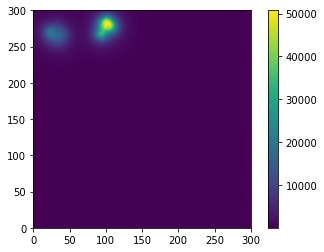

In [107]:
dtm_chr2_test = dtm_chr2_test.reshape((300, 300, 25))
fig, ax = plt.subplots()
im = ax.imshow(dtm_chr2_test[:, :, 10],
          extent=[0, 300, 0, 300],)
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
fig.colorbar(im)

plt.show()

In [73]:
chrom_dens = []
for chrom in tqdm.tqdm(range(1, 21)):
    chrom_coords = test_cell.query('`Chrom ID`==@chrom')[['x rel', 'y rel', 'z rel']].values
    dtm_kern.fit(chrom_coords)
    
    dtm_chrom = dtm_kern.transform(uniform_grid).reshape((300, 300, 25))
    dtm_chrom = dtm_chrom / np.sum(dtm_chrom)
    
    chrom_dens.append(dtm_chrom)

100%|██████████| 20/20 [04:34<00:00, 13.73s/it]


In [ ]:
chrom_dens = [

In [11]:
div = np.max(chrom_dens)

NameError: name 'np' is not defined

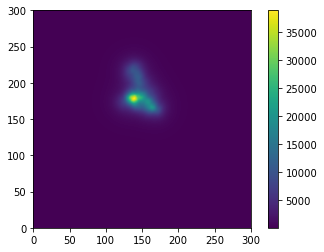

In [87]:
fig, ax = plt.subplots()
im = ax.imshow(scaled_dtm[10][10],
          extent=[0, 300, 0, 300],)
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
fig.colorbar(im)

plt.show()

In [90]:
# Rescale to 16 bit image and put in chr - z slice - x - y order
scaled_dtm = np.array([ (im * (2**16-1) / div).astype(np.uint16).transpose((2, 0, 1)) for im in chrom_dens ], dtype=np.uint16)

In [91]:
scaled_dtm.shape

(20, 25, 300, 300)

In [25]:
import skimage.io

In [92]:
skimage.io.imsave('dtm_bigcell_allchrom.tiff', scaled_dtm)

In [26]:
dtm_allchrom = skimage.io.imread('./dtm_bigcell_allchrom.tiff')

In [28]:
test_if_im = skimage.io.imread(f'/home/lincoln/CaiLab/IF_converted/Rep3-1/IF-Pos{fov}-Cell{cellid}-21x25x256x256.tiff')

test_if_im.shape

(21, 25, 256, 256)

In [31]:
test_if_im = np.pad(test_if_im, ((0, 0), (0, 0), (0, 44), (0, 44)), constant_values=0)

In [32]:
test_if_im.shape

(21, 25, 300, 300)

In [33]:
all_channels_im = np.concatenate([dtm_allchrom, test_if_im])

all_channels_im.shape

(41, 25, 300, 300)

In [34]:
skimage.io.imsave('dtm_bigcell_allchannels.tiff', all_channels_im)

## kNN

gudhi, sklearn, ...

In [65]:
def knn_density(k, dists):
    n = len(dists)
    
    # hardcoded 2-ball; different for other dimensions
    ball = (4/3)*np.pi
    
    factor = k / (n*ball)
    
    return factor / dists**3

In [66]:
knn = gpc.knn.KNearestNeighbors(k=50, return_index=False, return_distance=True, sort=True, implementation='sklearn', algorithm='ball_tree')

In [67]:
knn.fit(test_cell_coords)
knn_cell = knn.transform(uniform_grid)
# keep only maximum (last in ascending order) distance - to k'th neighbor
knn_cell = knn_cell[:, -1]
knn_cell_dens = knn_density(50, knn_cell)

/home/lincoln/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


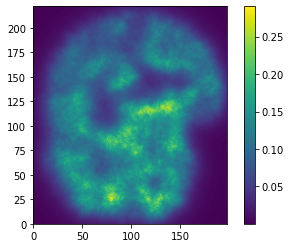

In [68]:
knn_cell_dens = knn_cell_dens.reshape((300, 300, 25))
fig, ax = plt.subplots()
im = ax.imshow(knn_cell_dens[:, :, 10],)
ax.set_xlim([0, if_bbox[0]])
ax.set_ylim([0, if_bbox[1]])
fig.colorbar(im)

plt.show()

In [116]:
knn.fit(test_chr2)
knn_chr2 = knn.transform(uniform_grid)
# keep only maximum (last in ascending order) distance - to k'th neighbor
knn_chr2 = knn_chr2[:, -1]
knn_chr2_dens = knn_density(10, knn_chr2)

/home/lincoln/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


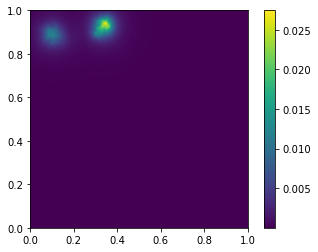

In [117]:
knn_chr2_dens = knn_chr2_dens.reshape((300, 300, 25))
fig, ax = plt.subplots()
im = ax.imshow(knn_chr2_dens[:, :, 10],
          extent=[0, 1, 0, 1],)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.colorbar(im)

plt.show()

## Kernel distance

In [414]:
np.sum(np.exp(-np.square(np.array([[2, 3], [4, 5]]))/4))

0.49352475875826857

In [118]:
class KDist:
    def __init__(
        self,
        bw_method=None,
        # kernel options, metric...
    ):
        self.factor = bw_method
        self.dim = None
        self.n = None
        self.fit_pdists = None
        
    def fit(
        self,
        X,
        Y=None
    ):
        # Assuming n observations by d dimensions
        self.dim = X.shape[1]
        self.n = X.shape[0]
        self.X = X
        self.fit_squared_pdists = np.square(sp.distance.squareform(sp.distance.pdist(X)))
        
        if self.factor is None:
            self.factor = self.n ** (-1/(self.dim+4))
            
        self.first_term = (1. / self.n**2) * np.sum( np.exp(-(self.fit_squared_pdists) / (2*self.factor**2)) )
        
    def transform(
        self,
        Y=None
    ):
        if Y.shape[1] != self.dim:
            raise np.AxisError('Dimension of Y must be the same as X, {}'.format(self.dim))
        
        # makes self.n by Y.m matrix of distances
        squared_cdists = np.square(sp.distance.cdist(self.X, Y))
        
        gaussian_cdists = np.exp(-(squared_cdists) / (2*self.factor**2))
        
        summed_gaussians = np.sum(gaussian_cdists, axis=0)
        
        return 1 - np.sqrt( self.first_term + 1 - (2./self.n) * summed_gaussians )

In [ ]:
kdist_kern = KDist(bw_method=0.03)

kdist_kern.fit(test_cell_coords)

kdist_cell = kdist_kern.transform(uniform_grid)

In [1]:
kdist_cell.shape

NameError: name 'kdist_cell' is not defined

In [518]:
kdist_kern.first_term

0.0019504930977838027

In [519]:
kdist_kern.factor

0.03

In [520]:
kdist_cell

array([-0.00097477, -0.00097477, -0.00097477, ..., -0.00097477,
       -0.00097477, -0.00097477])

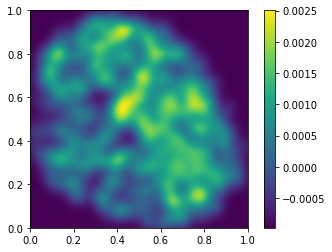

In [526]:
fig, ax = plt.subplots()
im = ax.imshow(kdist_cell.reshape(100, 100),
          extent=[0, 1, 0, 1],)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.colorbar(im)

plt.show()

In [522]:
kdist_kern.fit(test_chr2_normalized)

kdist_chr2 = kdist_kern.transform(fake_grid.T)

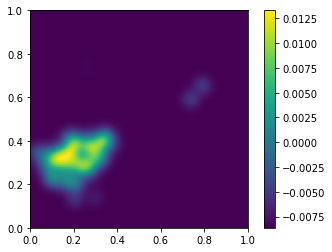

In [564]:
fig, ax = plt.subplots()
im = ax.imshow(kdist_chr2.reshape(100, 100),
          extent=[0, 1, 0, 1],)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.colorbar(im)

plt.show()

# Dashboard

In [565]:
import ipywidgets as widgets